## Loading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/Archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Pepper__bell___Bacterial_spot/33952a4a-ef41-4eff-9a2a-35bbea1b6686___JR_B.Spot 3200.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/ab10eb3c-cf6e-49bf-a220-2a7d3ffdb717___NREC_B.Spot 1961.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/1044c742-39a0-4b1a-984f-3cb2bdeda94b___NREC_B.Spot 9219.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/21f7119e-d926-4be3-9ace-d6b26b280e64___JR_B.Spot 8837.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/1219f26f-a23a-4c2a-99f0-407fc785c74a___JR_B.Spot 3332.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/9c23ddea-18e9-4b79-b890-77c6077d8966___JR_B.Spot 3195.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/6b1b260e-fab5-4a73-936c-5592119c13fe___NREC_B.Spot 1952.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/67e58468-8546-4324-8e1e-ae10abf2cb5b___JR_B.Spot 9099.JPG  
  inflating: train/Pepper__bell___Bacterial_spot/bc76d04a-056a-4fa4-a3d

## Preparing training, testing and validating set

In [3]:
import os

In [4]:
# Define the paths to the train, test, and validation directories
root = os.getcwd()
train_dir = os.path.join(root, "train")
test_dir = os.path.join(root, "test")
val_dir = os.path.join(root, "val")

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# Define the image data generators for each split
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Define the batch size
batch_size = 32

# Define the input shape
input_shape = (224, 224, 3)

In [8]:
# Define the training, testing, and validation generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size,
                                                  class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 19850 images belonging to 15 classes.
Found 3914 images belonging to 15 classes.
Found 3971 images belonging to 15 classes.


## Training the Inception_V3 model

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

# Loading the InceptionV3 model with pre-trained weights on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

num_classes = 15
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
epochs = 30
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

In [ ]:
# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

# Saving the model
model.save('inceptionv3_model.h5')

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/30
620/620 [==============================] - 297s 454ms/step - loss: 0.8425 - accuracy: 0.7309 - val_loss: 0.5939 - val_accuracy: 0.7921
Epoch 2/30
620/620 [==============================] - 288s 465ms/step - loss: 0.5338 - accuracy: 0.8207 - val_loss: 0.4237 - val_accuracy: 0.8538
Epoch 3/30
620/620 [==============================] - 281s 453ms/step - loss: 0.4628 - accuracy: 0.8386 - val_loss: 0.3981 - val_accuracy: 0.8586
Epoch 4/30
620/620 [==============================] - 280s 451ms/step - loss: 0.4247 - accuracy: 0.8529 - val_loss: 0.3186 - val_accuracy: 0.8813
Epoch 5/30
620/620 [==============================] - 269s 434ms/step - loss: 0.3878 - accuracy: 0.8666 - val_loss: 0.3070 - val_accuracy: 0.8884
Epoch 6/30
620/620 [==============================] - 280s 452ms/step - loss: 0.3760 - accuracy: 0.8686 - val_loss: 0.3457 - val_accuracy: 0.8760
Epoch 7/30
620/620 [==============================] - 278s 

### Model Accuracy on test set

In [12]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Inception_V3 test accuracy:', test_acc)

123/123 [==============================] - 475s 4s/step - loss: 0.1875 - accuracy: 0.9374
Inception_V3 test accuracy: 0.937404215335846


## Fine tuning the model to increase the accuracy

In [ ]:
from keras.optimizers import SGD

# Unfreeze the last few layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile the model with a SGD optimizer and a categorical cross-entropy loss function
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

# Save the model
model.save('inceptionv3_finetuned_model.h5')

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
620/620 [==============================] - 276s 426ms/step - loss: 0.1248 - accuracy: 0.9558 - val_loss: 0.1101 - val_accuracy: 0.9655
Epoch 2/30
620/620 [==============================] - 263s 424ms/step - loss: 0.1115 - accuracy: 0.9602 - val_loss: 0.1062 - val_accuracy: 0.9665
Epoch 3/30
620/620 [==============================] - 257s 414ms/step - loss: 0.1057 - accuracy: 0.9635 - val_loss: 0.1034 - val_accuracy: 0.9655
Epoch 4/30
620/620 [==============================] - 255s 411ms/step - loss: 0.1065 - accuracy: 0.9620 - val_loss: 0.1015 - val_accuracy: 0.9670
Epoch 5/30
620/620 [==============================] - 261s 421ms/step - loss: 0.0985 - accuracy: 0.9651 - val_loss: 0.0994 - val_accuracy: 0.9665
Epoch 6/30
620/620 [==============================] - 251s 405ms/step - loss: 0.1001 - accuracy: 0.9643 - val_loss: 0.0969 - val_accuracy: 0.9682
Epoch 7/30
620/620 [==============================] - 262s 423ms/step - loss: 0.0967 - accuracy: 0.9664 - val_loss: 0.0961 -

### Fine tuned model Accuracy on test set

In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Inception_V3 fine tuned test accuracy:', test_acc)

123/123 [==============================] - 18s 135ms/step - loss: 0.1024 - accuracy: 0.9658
Test accuracy: 0.9657639265060425


## Sample Prediction

In [10]:
!unzip gdrive/MyDrive/inceptionv3_models.zip

Archive:  gdrive/MyDrive/inceptionv3_models.zip
  inflating: inceptionv3_finetuned_model.h5  
  inflating: inceptionv3_model.h5    


In [13]:
# loading the saved model
from keras.models import load_model
model = load_model('inceptionv3_finetuned_model.h5')

In [14]:
from keras.utils import load_img, img_to_array
import numpy as np
from keras.applications.inception_v3 import preprocess_input

In [19]:
class_names = {
 0: 'Pepper__bell___Bacterial_spot',
 1: 'Pepper__bell___healthy',
 2: 'Potato___Early_blight',
 3: 'Potato___Late_blight',
 4: 'Potato___healthy',
 5: 'Tomato_Bacterial_spot',
 6: 'Tomato_Early_blight',
 7: 'Tomato_Late_blight',
 8: 'Tomato_Leaf_Mold',
 9: 'Tomato_Septoria_leaf_spot',
 10: 'Tomato_Spider_mites_Two_spotted_spider_mite',
 11: 'Tomato__Target_Spot',
 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 13: 'Tomato__Tomato_mosaic_virus',
 14: 'Tomato_healthy'}

In [23]:
img_path = '/content/test_img.JPG'

1/1 [==============================] - 0s 141ms/step


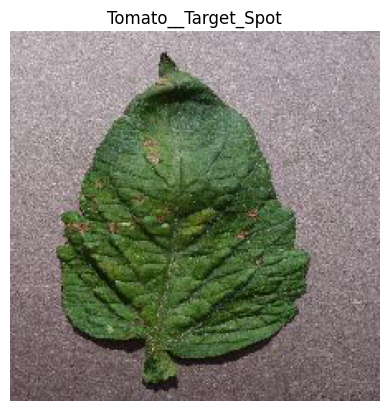

In [26]:
# Load a sample image
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
preds = model.predict(x)
class_idx = np.argmax(preds[0])
predicted_label = class_names[class_idx]
# print(class_idx)

# Display the image and prediction
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()